# Notebook for RETRIEVAL AUGMENTED GENERATION
This notebook is structured so that you can adjust the code to work with your scenario and tune it for different combinations of chunking parameters.
The values we'll be focusing on here are chunking size (in tokens) and overlap between consecutive chunks (also in tokens). As these values are used throughout the code, we recommend setting them in the beginning of the notebook, as part of step 0.

The notebook is structured so that you need to run it from Step 0, but if you already successfully completed any steps between 1 and 4 as part of previous runs, they can be skipped. This is convenient for time saving when you work with data volumes that require substantial amount of time for processing.

### Step 0. Initialization of the environment and workspace
If you have conda installed, you can create a new environment with the following command:
```bash
conda env create -f environment.yml
conda activate rag-e2e
```
This is the part where we read configuration and import modules that will be needed throughout the notebook. 

To enable running notebook from VS code, run the following line:

```bash
conda install -n rag-e2e ipykernel --update-deps --force-reinstall
```

#### Set Up Azure OpenAI Service and deploy a model

To set up Azure OpenAI service, you need to have an Azure subscription. If you don't have one, you can create a free account [here](https://azure.microsoft.com/en-us/free/). 

Once you have an Azure subscription, you can create an Azure OpenAI service instance by following the instructions [here](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource). For this tutorial, you also need to deploy "text-embedding-ada-002" model following instructions on the same page. Make sure to set the deployment name same as the model name.

Make a note of the Azure OpenAI service endpoint and key. You need to update __OPENAI_API_BASE__ and __OPENAI_API_KEY__ variables in the environment file used later.

#### Set Up Azure AI Search Service

To set up Azure AI Search Service, you need to have an Azure subscription. If you don't have one, you can create a free account [here](https://azure.microsoft.com/en-us/free/). Once you have an Azure subscription, you can create an Azure AI Search Service by following the instructions [here](https://docs.microsoft.com/en-us/azure/search/search-create-service-portal) or [here](https://learn.microsoft.com/en-us/azure/search/search-create-service-portal).

You may choose a free tier for the Azure AI Search Service, which allows you to have 3 indexes and 50 MB of storage. The free tier is sufficient for this notebook.

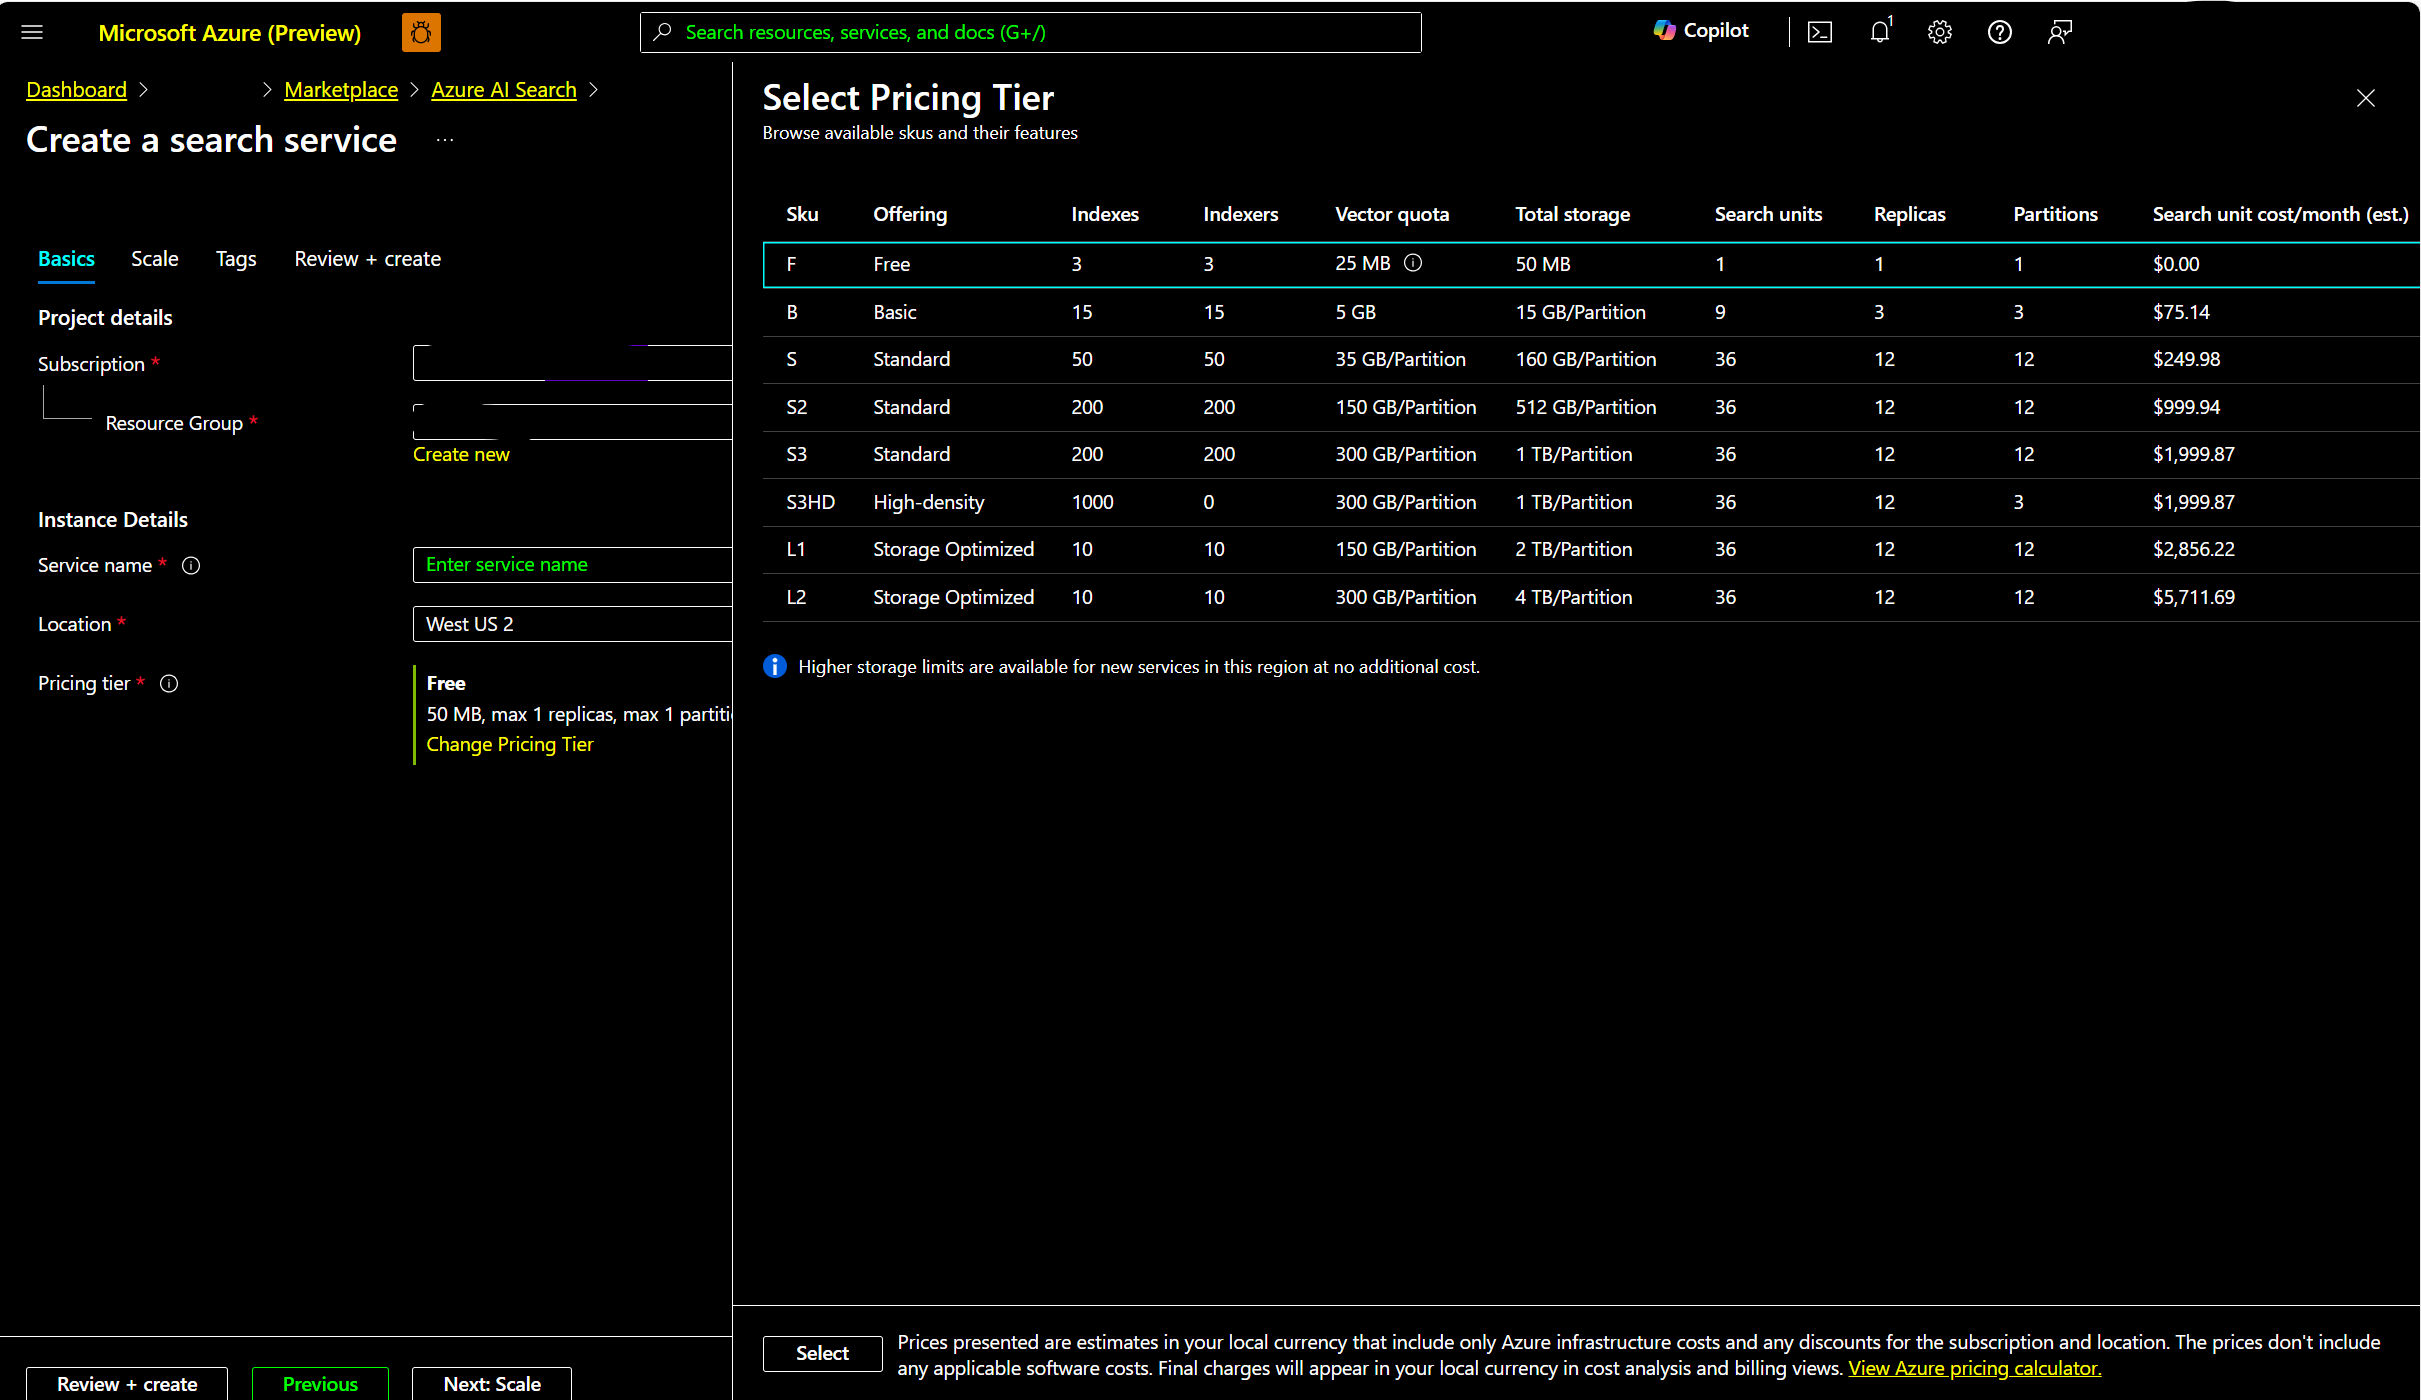

Make a note of the URL and API keys. You need to update __COGSEARCH_NAME__ and __COGSEARCH_API_KEY__ variables in the environment file used later.

In [ ]:
from dotenv import dotenv_values
import json
from pathlib import Path
import os
import pandas as pd
import re
import numpy as np
import time 
import PyPDF2
from azure.core.credentials import AzureKeyCredential

# specify the name of the .env file name
# This env file needs to be updated with Azure services specific information, as mentioned above
env_name = "../../../examples.env" # change to your own .env file name
config = dotenv_values(env_name)

Next, we set up configuration for the experiment via 3 variables. For considerations on picking most reasonable values for your scenarios, check aka.ms/chunk_size.

In [ ]:
dataset_name = "mft"
chunk_size=2048
chunk_overlap=10
top_n=2

Below we're printing an identifier name for the experiment derived from the parameters configured above. It will be used in the rest of the notebook as part of filenames, configuration of generated indices, etc. It allows to immediately say which parameters were used in the run (e.g. here it's "Microsoft financial transcripts" dataset, with chunksize of 2048 tokens and overlap of 10 tokens between them). Preserving it for tracking purposes and benchmarking is useful

In [ ]:
experiment_name = f"{dataset_name}_top{top_n}n_s{chunk_size}t_o{chunk_overlap}t"
print(experiment_name)

### Step1: Download and transform data

The purpose of this step we have already collected, curated and transformed data to pdf format, in the DATA subdirectory. The data is in the form of PDF files, and we will convert it to a JSON format that can be used by the RAG model.
Original sources are from here, for example: Msft Earning Call Transcripts for 2023-Q4
https://www.fool.com/earnings/call-transcripts/2023/07/25/microsoft-msft-q4-2023-earnings-call-transcript/


Convert the PDF files into text with positional metadata and dump intermediate results as json files locally (this way you don't have to run the notebook from scratch every time, you can start from the step where you left off). 

This code sample shows pypdf2 library usage to extract text from PDF files. It is a simple and easy-to-use library for reading PDF files. It is not the most powerful library, but it is sufficient for this task. For production level use, you may use Azure Document Intelligence or other libraries.

To learn more, please visit the documentation - Quickstart: Form Recognizer Python client library SDKs
https://docs.microsoft.com/en-us/azure/applied-ai-services/form-recognizer/quickstarts/try-v3-python-sdk

In [ ]:
# Extract line number and page number

def create_tuples_with_position_metadata(pdf_reader, file_name):
    """
    Input: PDF reader object from PyPDF2
    Output: Create list of tuples of the form (line, position)
    This will keep reference of the line number and page number of each line in the document.
    """
    line_page_tuples = []
    
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        text = page.extract_text()
        lines = text.split('\n') if text else []
        
        for line_num, line in enumerate(lines):
            line_page_tuples.append((line, f"{file_name}, P.{page_num + 1}, line {line_num + 1}"))
    
    return line_page_tuples

In [ ]:
import io
def analyze_pdf(doc_path):
    """
    Analyze PDF and return the PDF reader object.
    """
    with open(doc_path, "rb") as f:
        pdf_bytes = f.read()
    pdf_reader = PyPDF2.PdfReader(io.BytesIO(pdf_bytes))
    return pdf_reader

doc_dir = Path("DATA/")
pdf_files = [filename for filename in os.listdir(doc_dir) if filename.endswith('.pdf')]


for file_name in pdf_files:
    file_path_in = os.path.join(doc_dir, file_name)
    
    # analyze the pdf using PyPDF2
    pdf_reader = analyze_pdf(file_path_in)
    
    line_position_tuples = create_tuples_with_position_metadata(pdf_reader, file_name)

    # Saving results to json files
    output_dir = Path(f"AnalyzedPDF/{experiment_name}")
    if not output_dir.exists():
        output_dir.mkdir(parents=True, exist_ok=True)

    print('Writing the results of: \n' + file_name)
    file_path_out = output_dir / f"{os.path.splitext(file_name)[0]}.json"
    
    if not file_path_out.exists():
        # Convert and write JSON object to file
        with open(file_path_out, "w") as outfile:
            json.dump(line_position_tuples, outfile)
    else:
        print(f'{file_path_out} already exists, skipping...')

### Step 2. Preprocessing: Chunking, Embedding, and Filtering

In this stage we take text segments with positional references that was generated in stage 1 and dumped as json, and convert this input according to the specificaiton for chunking set in the beginning of this notebook. We also have custom code for adding filtering at later stage. If filtering is not needed, this code can be removed or simplified (instead of actual values for filtering, dummy value can be added)

In [ ]:

# Extract stock symbol, year, and quarter from filename
def extract_info_from_filename(filename):
    '''
    Input: filename ("MSFTTranscriptFY23Q4")
    Output: Extract stock symbol, year and quarter from filename
    '''
    pattern = r'([A-Z]+)TranscriptFY(\d{2})Q(\d)'
    match = re.search(pattern, filename)
    
    if match:
        symbol = match.group(1)
        fiscal_year = match.group(2)
        fiscal_quarter = match.group(3)
        return symbol, fiscal_year, fiscal_quarter
    else:
        return None
    
# Break the text `lines_with_position_metadata` into chunks of given length (in tokens) `chunk_length` with `chunk_overlap_length` overlap
def chunk_in_tokens(lines_with_position_metadata, chunk_length, chunk_overlap_length):
    return chunk_in_chars(lines_with_position_metadata, chunk_length*4, chunk_overlap_length*4)

# Break the text `lines_with_position_metadata` into chunks of given length (in chars) `chunk_length` with `chunk_overlap_length` overlap
def chunk_in_chars(lines_with_position_metadata, chunk_length, chunk_overlap_length):
    chunks = []
    current_chunk = ""
    current_position = 0
    for line, position in lines_with_position_metadata:
        while len(line) > chunk_length:
            chunks.append((line[:chunk_length], position))
            line = line[chunk_length - chunk_overlap_length:]
            current_position += chunk_length - chunk_overlap_length
        current_chunk = current_chunk + line + " "
        if len(current_chunk) >= chunk_length:
            chunks.append((current_chunk[:chunk_length], position))
            current_chunk = current_chunk[chunk_length - chunk_overlap_length:]
            current_position =  chunk_length - chunk_overlap_length
        else:
            current_chunk += " "
    if current_chunk:
        chunks.append((current_chunk, position))
    return chunks


In [ ]:
doc_dir = Path(f"AnalyzedPDF/{experiment_name}") 
files = [filename for filename in os.listdir(doc_dir) if filename.endswith('.json')]

dfs = []

for file_name in files:
    
    file_path = os.path.join(doc_dir, f"{os.path.splitext(file_name)[0]}.json")
    # Opening JSON file
    f = open(file_path)
    
    # returns JSON object as dictionary
    data = json.load(f)

    # get the chunks in a tuple of the form (chunk, page_number, line_number)
    chunks = chunk_in_tokens(data, chunk_size, chunk_overlap)   

    # Write results to dataframe 
    df_chunks = pd.DataFrame(chunks, columns = ['Chunk', 'Position'])  

    # todo: one field called 'Filter' instead of individual fields
    df_chunks["Ticker"], df_chunks["Year"], df_chunks["Quarter"]  = "NULL", "NULL", "NULL"

    values = extract_info_from_filename(file_name) # symbol, fiscal_year, fiscal_quarter
   
    if values:
        symbol, fiscal_year, fiscal_quarter = values
        df_chunks["Ticker"], df_chunks["Year"], df_chunks["Quarter"]  = symbol, fiscal_year, fiscal_quarter
        
    # Reorder dataframe column name
    new_column_order = ['Ticker', 'Year', 'Quarter', 'Chunk', 'Position']
    df_chunks = df_chunks[new_column_order]
        
    # Add all datframe to list
    dfs.append(df_chunks)
 

    print('writing the results of: \n' + file_name)  
    file_path=f"AnalyzedPDF/{experiment_name}/Chunks_{experiment_name}_{file_name[0:-4]}.csv"
    if not os.path.exists(file_path):
        df_chunks.to_csv(file_path, index=False)
    else:
        print(f'{file_path} already exists, skipping...')
        
## Combine all the files
df = pd.concat(dfs, ignore_index=True)
df = df.reset_index(drop=True)
df.insert(0, 'Id', [i for i in range(1, df.shape[0]+1)]) # Add 'Id' column

## Save to csv
df.to_csv(f"AnalyzedPDF/{experiment_name}/Chunks_{experiment_name}.csv", index=False)

df.head()


#### Load the chunks and create embedding
In this section, we will load the data into a pandas dataframe, use select columns, and create vector embedding using azure open ai. 

In [ ]:
import openai
from openai import AzureOpenAI
from tenacity import retry, wait_random_exponential, stop_after_attempt  

"""
openai.api_type = config["OPENAI_API_TYPE"]
openai.api_key = config["OPENAI_API_KEY"]
openai.api_base = config["OPENAI_API_BASE"] 
openai.api_version = config["OPENAI_API_VERSION"] 

""" 
    
client = AzureOpenAI(
  api_key =  config["OPENAI_API_KEY"],  
  api_version = "2023-05-15",
  azure_endpoint = config["OPENAI_API_BASE"]
)

model: str = "text-embedding-ada-002" # Use the deploymnet name of the model
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
# Function to generate embeddings for title and content fields, also used for query embeddings
def createEmbeddings(text, model=model):
    return client.embeddings.create(input = [text], model=model).data[0].embedding


df = pd.read_csv(f"AnalyzedPDF/{experiment_name}/Chunks_{experiment_name}.csv")

# Create a new column called 'embedding' in the DataFrame
df['Embedding'] = np.empty((len(df),), dtype=object)

# Iterate over each row in the DataFrame and assign the concatenation and embeddings
for index, row in df.iterrows():
    text = row['Chunk']
    
    # Concatenate the desired columns
    concat_text = f"{text}"
    
    # Create embeddings using the provided function
    embeddings = createEmbeddings(concat_text)
    
    # Assign the embeddings to the 'embedding' column
    df.at[index, 'Embedding'] = embeddings
    time.sleep(0.1)


Check the output:

In [ ]:
df.head(10)

Use the following code to save the embeddings and processed data for future use or skip the previous part of the code and load the processed data to save into the db. 

In [ ]:
# save CSV for future use. 
df.to_csv(f"AnalyzedPDF/{experiment_name}/ChunksEmbedding_{experiment_name}.csv", index=False)

### Store chunks into Vector Database using Azure Cognitive Search (ACS)

In [ ]:
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import Vector  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField, 
    SemanticConfiguration,  
    PrioritizedFields,  
    SemanticField,  
    SemanticSettings,  
    VectorSearch,  
    HnswVectorSearchAlgorithmConfiguration
)
from ast import literal_eval

Load environment variables and keys:

In [ ]:
## Azure AI Search
index_name = config["COGSEARCH_INDEX_NAME"]
key = config["COGSEARCH_API_KEY"]
service_endpoint = config["COGSEARCH_ADDRESS"]  

credential = AzureKeyCredential(key)

Load data prepared at previous steps:

In [ ]:
df_chunks_embedding = pd.read_csv(f"AnalyzedPDF/{experiment_name}/ChunksEmbedding_{experiment_name}.csv")
df_chunks_embedding.head(3)

Created index configurations:

In [ ]:
# Create a search index
index_name=f"index__{experiment_name}"
vs_config_name=f"{experiment_name}-vector-config"


index_client = SearchIndexClient(
    endpoint=service_endpoint, credential=credential)
fields = [
    SimpleField(name="Id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="Filter", type=SearchFieldDataType.String, filterable=True),
    SearchableField(name="Chunk", type=SearchFieldDataType.String, searchable=True),
    SearchableField(name="Position", type=SearchFieldDataType.String, filterable=True),
    SearchField(name="Embedding", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                searchable=True, vector_search_dimensions=1536, vector_search_configuration=vs_config_name),
]


vector_search = VectorSearch(
    algorithm_configurations=[
        HnswVectorSearchAlgorithmConfiguration(
            name=vs_config_name,
           # name="my-vector-config",
            kind="hnsw",
            parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 500,
                "metric": "cosine" # cosine, euclidean, and dotProduct are valid metrics
            }
        )
    ]
)

ss_config_name=f"{experiment_name}-semantic-config"
semantic_config = SemanticConfiguration(
    name=ss_config_name,
    #name="my-semantic-config",
    prioritized_fields=PrioritizedFields(
        title_field=SemanticField(field_name="Filter"),
        prioritized_content_fields=[SemanticField(field_name="Chunk")]
    )
)

# Create the semantic settings with the configuration
semantic_settings = SemanticSettings(configurations=[semantic_config])

# Create the search index with the semantic settings
index = SearchIndex(name=index_name, fields=fields,
                    vector_search=vector_search, semantic_settings=semantic_settings)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

Finally, upload prepared data to index:

In [ ]:

## Upload data to Index
def batch_append_payload(df, search_client):
    """append payload for batch insertion (note: max 1000 rows per insertion) of embeddings to Cognitive Search"""
    value_list = []
    for index, row in df.iterrows():
        value_list.append(
            {
                "Id": str(index),
                "Filter": str(row["Ticker"])+"FY"+str(row["Year"])+"Q"+str(row["Quarter"]),
                "Chunk": row["Chunk"],
                "Position": str(row["Position"]),
                "Embedding": literal_eval(row['Embedding']),
            }
        )
        
        if len(value_list) >= 1000:
            result = search_client.upload_documents(value_list)
            print(f"Uploaded {len(value_list)} payload")
            value_list = []
    result = search_client.upload_documents(value_list)
    print(f"Uploaded {len(value_list)} payload")

    return value_list

search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
payload = batch_append_payload(df_chunks_embedding, search_client)

### Step 3. Types of Retrievals

#### Search Type 1: Pure Vector Search

Pure vector search involves searching for the most similar vectors to the query vector. This is the most basic form of search and is used to find the most similar documents to the query, based on the vector embeddings similarity search. Note that search type

In [ ]:
query = "How many monthly active users does Power BI have in FY23Q1?"
    
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
vector = Vector(value=createEmbeddings(query), k=5, fields="Embedding")  

results = search_client.search(  
    search_text=None,  
    vectors=[vector]
)  

context=""
for result in results: 
  print(result['Chunk'])
  context+=result["Chunk"]
print(context)

### Search Type 2: Pure Filter Search

In [ ]:
# Find all chunks from FY23 Q2
results = search_client.search(  
    search_text=None,  
    filter="(Filter eq 'MSFTFY23Q2') ",
)  

for result in results:
    print(result)

### Search Type 3: Hybrid Search

In [ ]:
# Extract quarter of earnings pubication
def extract_time_context(line: str) -> str:
    match = re.search(r"\bFY\d{2}Q\d\b", line)
    if match:
        return match.group()
    else:
        return ""

In [ ]:
# Example usage
sentence1 = "How many monthly active users does Power BI have in FY23Q1?"
sentence2 = "What are some examples of companies using Azure OpenAI Service in FY23Q2?"
print(extract_time_context(sentence1))  # Output: FY23Q1
print(extract_time_context(sentence2))  # Output: FY23Q2

In [ ]:
for result in results: 
  print(result)


In [ ]:
query = "How many monthly active users does Power BI have in FY23Q1?"
filter_value='MSFT'+extract_time_context(query)
    
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
vector = Vector(value=createEmbeddings(query), k=5, fields="Embedding")   # k = number of similar chunks

results = search_client.search(  
    search_text=None,  
    vectors=[vector],
    filter = f"(Filter eq '{filter_value}')"
)  

# Convert the search results into a pandas DataFrame
df = pd.DataFrame(results)
df

### Step 5. Evaluation of ALL Retrievals

Define a helper functions to retrieve relevant chunks from the storage:

In [ ]:
# function to fetch top `n` "best matching" results for a `query` 
def fetch_relevant_chunks_as_df(query, n=1):
    filter_value = 'MSFT' + extract_time_context(query)
    search_client = SearchClient(service_endpoint, index_name, credential=credential)
    vector = Vector(value=createEmbeddings(query), k=n, fields="Embedding")

    results = search_client.search(
        search_text=None,
        vectors=[vector],
        filter=f"(Filter eq '{filter_value}')"
    )

    rows = [
        {
            'position': result.get('Position'),
            'chunk': result.get('Chunk'),
            'filter': result.get('Filter'),
            'score': result.get('@search.score'), # The relevance score of the result
            'question': query
        }
        for result in results
    ]

    if not rows:
        print(f"No results found for query: {query}")

    return pd.DataFrame(rows)

# function to fetch top `n` "best matching" results for multiple queries
def fetch_relevant_chunks_for_multiple_questions(queries, n=1):
    return pd.concat(
        [fetch_relevant_chunks_as_df(query, n) for query in queries],
        ignore_index=True
    )

# Example usage
queries = [
    "How many monthly active users does Power BI have in FY23Q1?", 
    "Which companies run SAP on Azure in FY23Q1?"
]
result_df = fetch_relevant_chunks_for_multiple_questions(queries, 5)
result_df

Load human-curated QA benchmark file:

In [ ]:
benchmark_file="evalset.csv"
doc_dir = Path("DATA/") 
file_path = os.path.join(doc_dir, benchmark_file)
benchmark=pd.read_csv(file_path) 
benchmark

(for how to create a larger custom benchmark automatically with the help of LLM, see our article at Data Science @ Microsoft blog https://medium.com/data-science-at-microsoft/the-path-to-a-golden-dataset-or-how-to-evaluate-your-rag-045e23d1f13f)

Fetch chunks that are relevant to answering benchmark questions:

In [ ]:
questions_list = benchmark['question'].tolist()
relevant_chunks=fetch_relevant_chunks_for_multiple_questions(questions_list, top_n)
merged_df = pd.merge(relevant_chunks, benchmark, on='question')
merged_df

Define template for the ptrompt to serve these chunks to LLM along with questions to generate answers in conversational form:

In [ ]:
template = """
        You are given a question and a relevant piece of context. Use only the context to answer the question.
            If answer is not available in the text, say it is not available.
               
        An example:
        question: "How many developers are using GitHub Copilot as of FY23Q2?": 
        context: <relevant context>
        answer: "More than one million people have used GitHub Copilot to date."

        Go!
        question:
        {question}
        context: 
        {context} 
        answer:
        <your answer here>
        """

Then, define a function with configuration of instructions to LLM on what we expect from it (note that we use gpt-4o model here):

In [ ]:
def get_answer_from_context(question, context):
    response = client.chat.completions.create(
        model="gpt-4o", 
        messages=[
            {"role": "system", "content":"You are an expert in finance and are tasked with providing answers to questions within a document." },
            {"role": "user", "content": template.format(context=context, question=question)}
        ]
    )

    return response.choices[0].message.content

Test the function on one sample:

In [ ]:
sample_question, human_answer = benchmark.loc[1, 'question'], benchmark.loc[1, 'answer']
results= merged_df[merged_df['question'] == sample_question]
context = " \n* ".join(results['chunk'].values)
gen_answer = get_answer_from_context(sample_question, context)
print(f"Sample question: {sample_question}\nRetrieved context: \n* {context}\nGenerated answer: {gen_answer} \nGround truth: {human_answer}")

Now, let's apply it to the whole set of questions:

In [ ]:
# helper function to go generate multiple answers for a dataframe that contains 'question' and 'chunk' columns
def generate_answers_from_context(df):
    # Aggregate 'chunk' values by 'question'
    aggregated_data = df.groupby('question')['chunk'].apply(lambda x: "".join(x)).reset_index()

    # Iterate over each row in the aggregated data
    for index, row in aggregated_data.iterrows(): 
        # Use the aggregated context
        context = row['chunk']
        # Get the answer from the context
        gen_ans = get_answer_from_context(row['question'], context)
        # Print the question and the generated answer
        print(row['question'], "\n", gen_ans)

# Call the function to process the dataframe
generate_answers_from_context(merged_df)

Run it again and notice if the output remained the same or changed:

In [ ]:
generate_answers_from_context(merged_df)

Exercise! As you can see, there's an opportunity to improve the performance - e.g. for some questions we see 'It is not available' response, even though the benchmark is curated based on the information that has been provided to the RAG system in full. Also, some questions were answered by the model in one run, but in the other it failed to do so, or articulated different level of confidence. This is a common problem for RAG systems. What would you try to solve it? Think about components of RAGs that may be optimized, try evaluating your hypothesis experimentally. 